In [1]:
using Agents
using LightGraphs
using Statistics: mean, sum
using GLMakie: lines
using Test: @test
using DataFrames
using CSV

# エージェントを定義する

In [2]:
const C = true
const D = false

mutable struct Player <: AbstractAgent
    id::Int
    pos::Int
    strategy::Bool # C or D
    next_strategy::Bool # C or D
    payoff::Float64
    
    Player(id::Int, strategy::Bool) = new(id, id, strategy, D, 0.0)
    Player(id::Int, c_rate::Float64) = new(id, id, rand() < c_rate, D, 0.0)
end

# Define pay-off table

||C|D|
|:-:|:-:|:-:|
|C|R|S|
|D|T|P|

In [3]:
struct PayOffTable
    T::Float64
    R::Float64
    P::Float64
    S::Float64
end

function PayOffTable_PD(b::Float64)::PayOffTable
    PayOffTable(b, 1, 0.00001, 0)
end

function PayOffTable_SD(r::Float64)::PayOffTable
    T = β = (1 / r + 1) / 2
    R = β - 1 / 2
    P = 0
    S = β - 1
    PayOffTable(T, R, P, S)
end

function play(payofftable::PayOffTable, me::Player, you::Player)::Float64
    payoff = nothing
    
    if me.strategy && you.strategy
        payoff = payofftable.R
    elseif me.strategy && !you.strategy
        payoff = payofftable.S
    elseif !me.strategy && you.strategy
        payoff = payofftable.T
    elseif !me.strategy && !you.strategy
        payoff = payofftable.P
    end
    
    return payoff
end

# Test
payofftable_pd = PayOffTable_PD(1.5)
@test play(payofftable_pd, Player(1, C), Player(1, C)) == 1
@test play(payofftable_pd, Player(1, C), Player(1, D)) == 0
@test play(payofftable_pd, Player(1, D), Player(1, C)) == 1.5
@test play(payofftable_pd, Player(1, D), Player(1, D)) == 0.00001

payofftable_sd = PayOffTable_SD(0.5)
@test play(payofftable_sd, Player(1, C), Player(1, C)) == 1
@test play(payofftable_sd, Player(1, C), Player(1, D)) == 0.5
@test play(payofftable_sd, Player(1, D), Player(1, C)) == 1.5
@test play(payofftable_sd, Player(1, D), Player(1, D)) == 0

Test Passed

# モデルとエージェントを生成する

In [4]:
function build_model(;G::SimpleGraph, payofftable::PayOffTable, c_rate::Float64)
    space = GraphSpace(G)
    model = ABM(Player, space, properties = Dict(:payofftable => payofftable))

    # モデル上にエージェントを配置する。
    for id in 1:nv(G)
        add_agent_pos!(Player(id, c_rate), model)
    end
    
    return model
end

# Test
model = build_model(G = random_regular_graph(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.8)
@test length(allagents(model)) == 104
@test model.properties[:payofftable].T == 1.5

Test Passed

# Define model behavior of 1step

In [17]:
function model_step!(model::AgentBasedModel)
    payofftable = model.properties[:payofftable]
    
    # In each generation, all pairs of individuals x and y, directly connected, engage in a single round of a given game,
    # their accumulated payoffs being stored as Px and Py, respectively.
    for agent in allagents(model)
        agent.payoff = 0
        for neighbor in nearby_agents(agent, model)
            agent.payoff += play(payofftable, agent, neighbor)
        end
        # agent.payoff = sum([play(payofftable, agent, neighbor) for neighbor in nearby_agents(agent, model)])
    end
    
    # decide next strategy by pay-off
    for agent in allagents(model)
        # Whenever a site x is updated, a neighbor y is drawn at random among all kx neighbors
        neighbors = nearby_agents(agent, model)
        neighbor_count = length(neighbors)
        neighbor = collect(neighbors)[rand(1:neighbor_count)]
        
        # whenever Py > Px the chosen neighbor takes over site x with probability given by (Py−Px)/(Dk>)
        # where k> is the largest between kx and ky and D=T−S for the PD and D=T−P for the SG
        Px = agent.payoff
        Py = neighbor.payoff
        D = payofftable.T - 0 # ∵ S = 0 for PD, P = 0 for SD
        kx = neighbor_count
        ky = length(nearby_agents(neighbor, model))
        k_max = kx > ky ? kx : ky
        take_over_ratio = (Py - Px) / (D * k_max)
        
        if Py > Px && take_over_ratio > rand()
            agent.next_strategy = neighbor.strategy
        else
            agent.next_strategy = agent.strategy
        end
    end
    
    # update strategy
    for agent in allagents(model)
        agent.strategy = agent.next_strategy
    end
end

# Test
# 0.019611 seconds (43.44 k allocations: 2.462 MiB, 96.83% compilation time)
# 3つのforループの中で最初のループがボトルネック
# Struct を Tuple に変えても変化なし
# インライン化しても変化なし
# 1つめのループ内の内包表現をfor文に変えて、変数を予め割り当てる
# 0.027275 seconds (60.34 k allocations: 3.378 MiB, 97.36% compilation time)
# =>
# 0.000204 seconds (2.22 k allocations: 121.672 KiB)
model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.5)
@time run!(model, dummystep, model_step!, 1; adata = [(:strategy, mean)])
@time run!(model, dummystep, model_step!, 1000; adata = [(:strategy, mean)])
nothing

  0.090902 seconds (80.98 k allocations: 4.485 MiB, 98.98% compilation time)
  0.353231 seconds (4.59 M allocations: 253.244 MiB, 9.33% gc time)


# シミュレーションを実行する

In [38]:
function exit_criteria(model::AgentBasedModel, s::Int)::Bool
    s > 6000 || mean([a.strategy for a in allagents(model)]) == 0.0 || mean([a.strategy for a in allagents(model)]) == 1.0
end

model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.5)
@test !exit_criteria(model, 6000)
model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.5)
@test exit_criteria(model, 6001)
model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.0)
@test exit_criteria(model, 6000)
model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 1.0)
@test exit_criteria(model, 6000)

Test Passed

In [39]:
function run_simulation(; scale_free::Bool, pd::Bool, b_r::Float64, N::Int = 104, k::Int = 4, N_trials::Int = 32)::Float64
    # Simulations were carried out for a population of N=104
    # Initially, an equal percentage of strategies (cooperators or defectors) was randomly distributed among the elements of the population.
    # Equilibrium frequencies of cooperators and defectors were obtained by averaging over 1000 generations after a transient time of 10 000 generations.
    c_rate = 0.5
    N_gen = 6000
    payofftable = pd ? PayOffTable_PD(b_r) : PayOffTable_SD(b_r)
    
    # To this end, each data point results from an average over 100 simulations for the same type of NOCs
    # specified by the appropriate parameters (the population size N and the average connectivity z).
    f_c = 0
    for _ in 1:N_trials
        G = scale_free ? barabasi_albert(N, k) : random_regular_graph(N, k)
        model = build_model(;G, payofftable, c_rate)
        temp_df, _ = run!(model, dummystep, model_step!, exit_criteria; adata = [(:strategy, mean)], when = 5401:6001)
        f_c += mean(temp_df.mean_strategy)
    end
    
    return f_c / N_trials
end

run_simulation (generic function with 1 method)

In [40]:
df = DataFrame(network_typ = String[], game_type = String[], b_r = Float64[], k = Int64[], f_c = Float64[])

,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64


In [41]:
# Regular Network / Prisoner's Dilemma / k = 4
for b_r in 1.00:0.05:1.20
    @time push!(df, ["Regular", "Prisoner's Dilemma", b_r, 4, run_simulation(; scale_free = false, pd = true, b_r)])
end
df

 50.023166 seconds (726.71 M allocations: 35.600 GiB, 9.15% gc time, 0.04% compilation time)
 48.766604 seconds (718.17 M allocations: 35.173 GiB, 8.89% gc time)
 41.934761 seconds (618.24 M allocations: 30.292 GiB, 8.91% gc time)
 34.315095 seconds (505.28 M allocations: 24.795 GiB, 8.92% gc time)
 30.589474 seconds (455.64 M allocations: 22.372 GiB, 8.83% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.705357
2,Regular,Prisoner's Dilemma,1.05,4,NaN
3,Regular,Prisoner's Dilemma,1.1,4,NaN
4,Regular,Prisoner's Dilemma,1.15,4,NaN
5,Regular,Prisoner's Dilemma,1.2,4,NaN


In [42]:
# Regular Network / Snowdrift Game
for b_r in 0.1:0.2:0.9
    @time push!(df, ["Regular", "Snowdrift", b_r, 4, run_simulation(; scale_free = false, pd = false, b_r)])
end
df

  5.538301 seconds (82.71 M allocations: 4.073 GiB, 8.86% gc time)
 49.573067 seconds (727.73 M allocations: 35.615 GiB, 8.66% gc time)
 49.620712 seconds (726.91 M allocations: 35.602 GiB, 8.66% gc time)
 48.136218 seconds (713.25 M allocations: 34.966 GiB, 8.65% gc time)
  5.145331 seconds (77.17 M allocations: 3.799 GiB, 8.88% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.705357
2,Regular,Prisoner's Dilemma,1.05,4,NaN
3,Regular,Prisoner's Dilemma,1.1,4,NaN
4,Regular,Prisoner's Dilemma,1.15,4,NaN
5,Regular,Prisoner's Dilemma,1.2,4,NaN
6,Regular,Snowdrift,0.1,4,NaN
7,Regular,Snowdrift,0.3,4,0.623112
8,Regular,Snowdrift,0.5,4,0.37665
9,Regular,Snowdrift,0.7,4,NaN


In [43]:
# Scale-Free Network / Prisoner's Dilemma
for b_r in 1.1:0.2:1.9
    @time push!(df, ["Scale-Free", "Prisoner's Dilemma", b_r, 4, run_simulation(; scale_free = true, pd = true, b_r)])
end
df

 11.249489 seconds (146.92 M allocations: 7.961 GiB, 8.84% gc time)
 10.674220 seconds (141.23 M allocations: 7.677 GiB, 8.84% gc time)
  7.866610 seconds (104.97 M allocations: 5.690 GiB, 8.91% gc time)
  2.568484 seconds (33.73 M allocations: 1.834 GiB, 8.90% gc time)
  1.813476 seconds (24.04 M allocations: 1.306 GiB, 9.52% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.705357
2,Regular,Prisoner's Dilemma,1.05,4,NaN
3,Regular,Prisoner's Dilemma,1.1,4,NaN
4,Regular,Prisoner's Dilemma,1.15,4,NaN
5,Regular,Prisoner's Dilemma,1.2,4,NaN
6,Regular,Snowdrift,0.1,4,NaN
7,Regular,Snowdrift,0.3,4,0.623112
8,Regular,Snowdrift,0.5,4,0.37665
9,Regular,Snowdrift,0.7,4,NaN


In [44]:
# Scale-Free Network / Snowdrift Game
for b_r in 0.1:0.2:0.9
    @time push!(df, ["Scale-Free", "Snowdrift", b_r, 4, run_simulation(; scale_free = true, pd = false, b_r)])
end
df

  6.741179 seconds (87.59 M allocations: 4.771 GiB, 8.82% gc time)
  9.419093 seconds (122.48 M allocations: 6.654 GiB, 8.82% gc time)
 20.501134 seconds (268.67 M allocations: 14.537 GiB, 8.85% gc time)
 32.703216 seconds (424.19 M allocations: 22.976 GiB, 8.96% gc time)
 59.345168 seconds (781.69 M allocations: 42.498 GiB, 8.85% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.705357
2,Regular,Prisoner's Dilemma,1.05,4,NaN
3,Regular,Prisoner's Dilemma,1.1,4,NaN
4,Regular,Prisoner's Dilemma,1.15,4,NaN
5,Regular,Prisoner's Dilemma,1.2,4,NaN
6,Regular,Snowdrift,0.1,4,NaN
7,Regular,Snowdrift,0.3,4,0.623112
8,Regular,Snowdrift,0.5,4,0.37665
9,Regular,Snowdrift,0.7,4,NaN


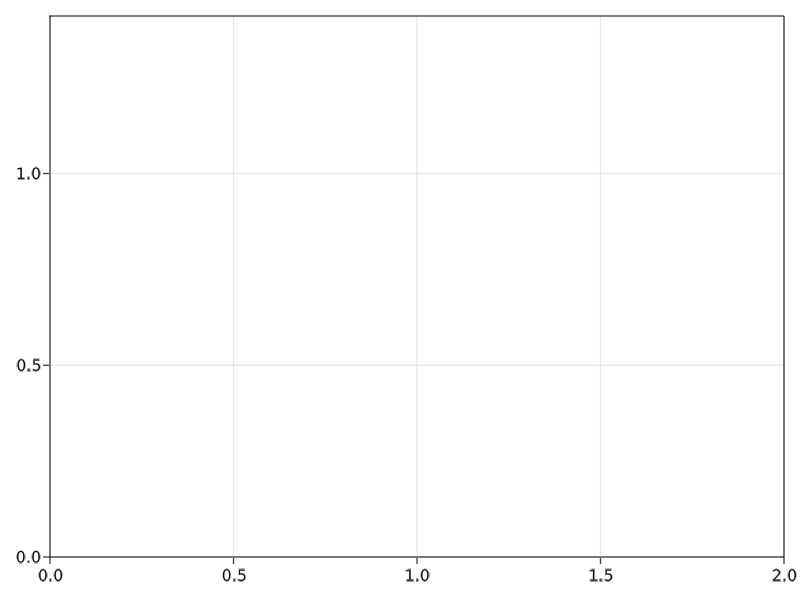

In [45]:
temp_df = df[(df.network_typ .== "Regular") .& (df.game_type .== "Prisoner's Dilemma"), :]
lines(temp_df.b_r, temp_df.f_c)

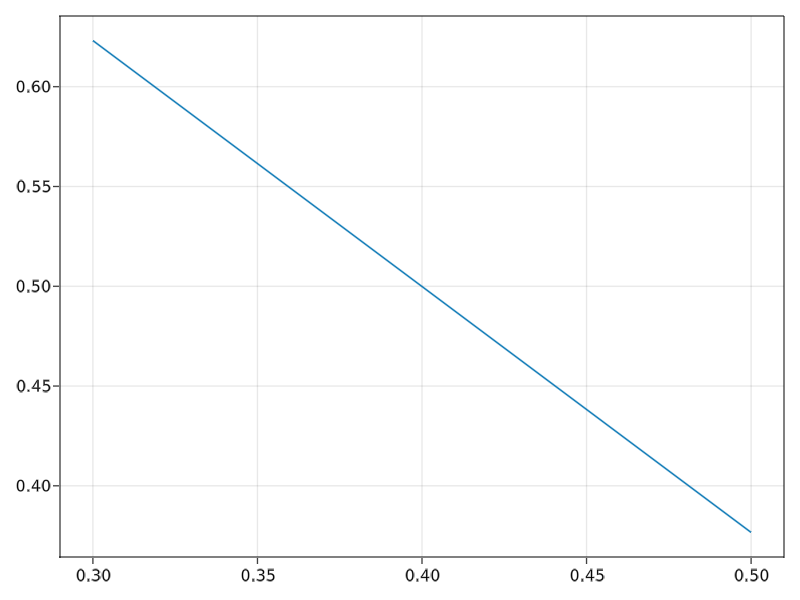

In [46]:
temp_df = df[(df.network_typ .== "Regular") .& (df.game_type .== "Snowdrift"), :]
lines(temp_df.b_r, temp_df.f_c)

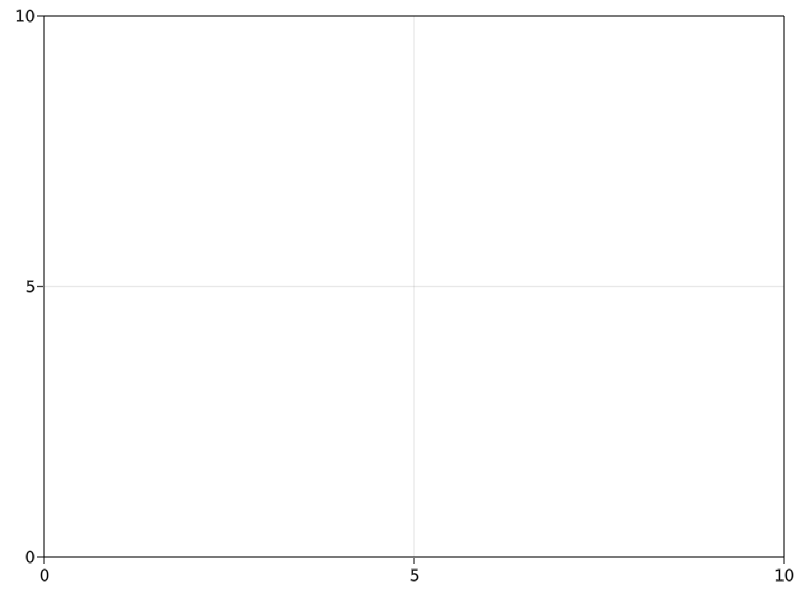

In [47]:
temp_df = df[(df.network_typ .== "Scale-Free") .& (df.game_type .== "Prisoner's Dilemma"), :]
lines(temp_df.b_r, temp_df.f_c)

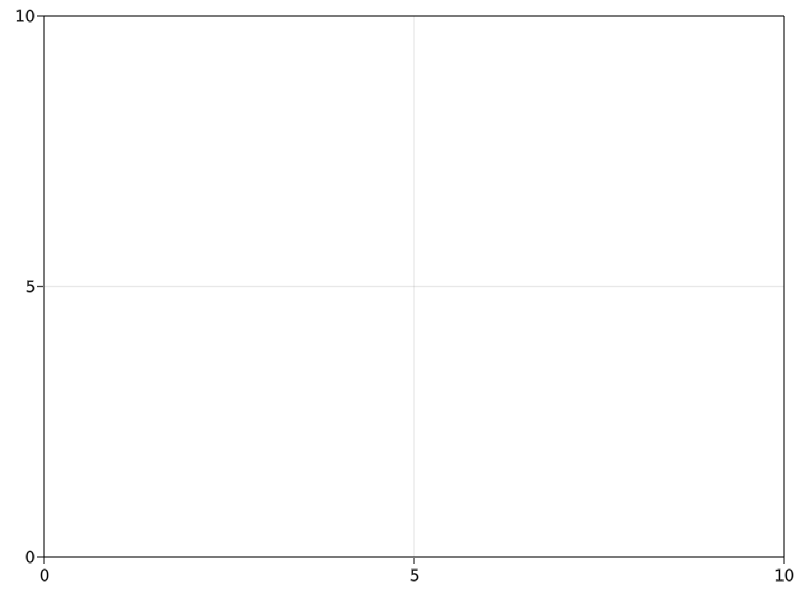

In [48]:
temp_df = df[(df.network_typ .== "Scale-Free") .& (df.game_type .== "Snowdrift"), :]
lines(temp_df.b_r, temp_df.f_c)

In [30]:
CSV.write("UnifyingFramework_20210728_2018.csv", df)

"UnifyingFramework.csv"